<h1>Import librearies</h1>

In [37]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

<h1>Import data</h1>

In [38]:
sales_data=pd.read_csv("train.csv")
print(sales_data.head())
sales_data.info()

         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


<h1>Drop store and item col </h1>

In [39]:
sales_data = sales_data.drop(['store', 'item'], axis=1, errors='ignore')
sales_data.info()
sales_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [40]:
# Ensure the 'date' column is of datetime type
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Convert the 'date' column to a monthly period
sales_data['date'] = sales_data['date'].dt.to_period("M")

# Group by the monthly period and sum the values
monthly_sales = sales_data.groupby('date').sum().reset_index()

# Convert the 'date' column back to a timestamp
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Display the first 10 rows of the result
monthly_sales.head(10)


,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


<h1>Visualization</h1>

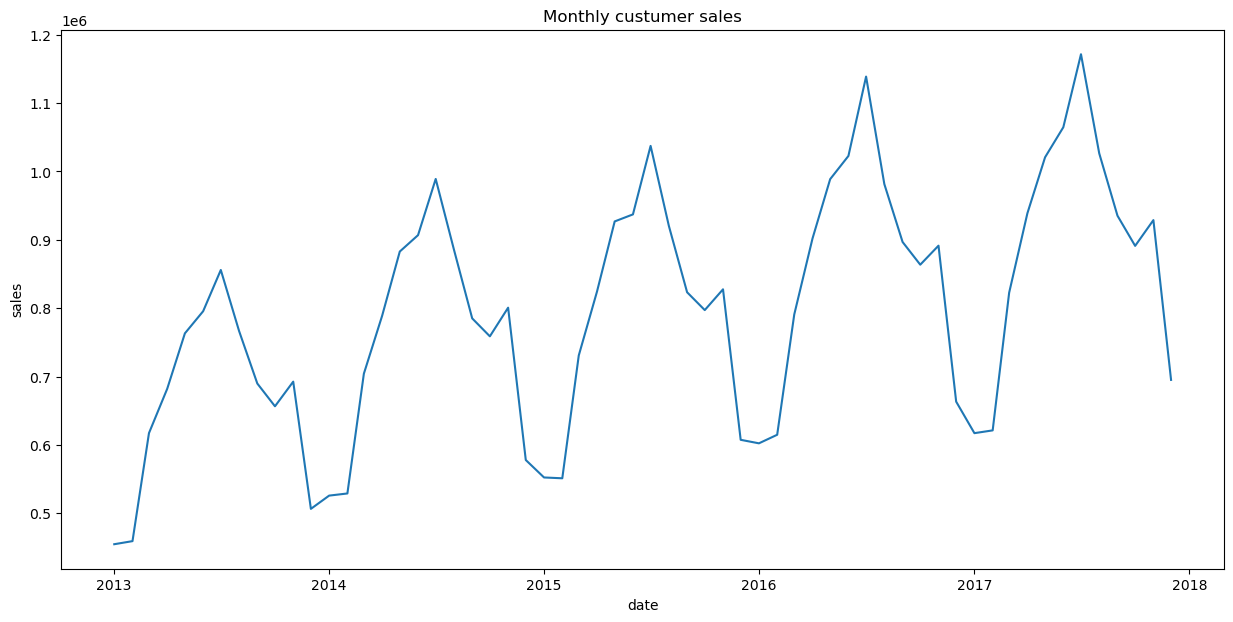

In [41]:
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("Monthly custumer sales")
plt.show()

In [42]:
monthly_sales['sales_diff']=monthly_sales["sales"].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


<h1>Prepare supervised data</h1>

In [43]:
suvervised_data=monthly_sales.drop(["date","sales"],axis=1)
print(f"Supervised data shape: \n{suvervised_data.shape}")
for i in range(1,13):
    col_name="month-"+str(i)
    suvervised_data[col_name]=suvervised_data['sales_diff'].shift(i)
suvervised_data=suvervised_data.dropna().reset_index(drop=True) 
suvervised_data.head()

Supervised data shape: 
(59, 1)


,sales_diff,month-1,month-2,month-3,month-4,month-5,month-6,month-7,month-8,month-9,month-10,month-11,month-12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


<h1>Training and Test set</h1>

In [44]:
train_data=suvervised_data[:-12]
test_data=suvervised_data[-12:]
print(f'Training set shape: {train_data.shape}\nTest set shape: {test_data.shape}')

Training set shape: (35, 13)
Test set shape: (12, 13)


<h1>Data preprocessing</h1>

In [45]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)
#check
print(train_data[1])

[ 0.97816867  0.12267595  0.20344758 -0.81758535  0.28633667 -0.05850103
 -0.27488947 -0.33606217  0.40696724  0.26794062  0.50957454  0.42966779
  0.8922929 ]


In [46]:
x_train,y_train=train_data[:,1:],train_data[:,0:1]
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()

In [47]:
print(f"x-train set shape:{x_train.shape}\ny-train set shape:{y_train.shape}\nx-test set shape:{x_test.shape}\ny-test set shape:{y_test.shape}")

x-train set shape:(35, 12)
y-train set shape:(35,)
x-test set shape:(12, 12)
y-test set shape:(12,)


<h1>Make prediction data frame</h1>

In [48]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [49]:
actual_sales=monthly_sales["sales"][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]
